In [404]:
import numpy as np  
import matplotlib.pyplot as plt  
import astropy.constants as c  
import astropy.units as u  

year  = (1*u.year).cgs.value
au    = c.au.cgs.value
M_jup = c.M_jup.cgs.value
M_sun = c.M_sun.cgs.value

gl_alpha = None

import os
import simple_slider

from simple_slider import Widget
from simple_slider import kanagawa_profile
from simple_slider import get_surface_density
from simple_slider import get_disk_height

from log_prob import log_prob_, conv_values, log_prob_alpha, params_format

%matplotlib notebook

In [405]:
true_alpha = [None, 1e-2, 1e-2, 1e-3, 1e-3, 1e-2, 1e-2, 1e-2, 1e-3, 1e-3, 1e-3, 1e-4, 1e-4, 1e-4,]
M_true_all = [1, 1e-3, 4e-4, 1e-3, 4e-4, 3e-3, 1e-3, 3e-4, 3e-3, 1e-3, 3e-4, 3e-3, 1e-3, 3e-4]

Select number of planets

Optional: Set desired alpha

Choose data set

In [406]:
##################
gl_n_planets = 2
##################
choose = 5
clow   = 11
chigh  = 13
##################
# Ignore Gap Depth {0,1,2} (only naming convetion)
IGD = 2
# SaVefig: {0,1,2} {off/corner&plot/all} 
SV  = 0
##################
#gl_alpha = 1e-3
##################

In [407]:
try:
    if new_choose < len(switcher):
        choose = new_choose
except Exception:
    new_choose = choose

M_true = M_true_all[choose]
gl_alpha = true_alpha[choose]

try:
    set_alpha = int(gl_alpha**0)
except Exception:
    set_alpha = 0

In [408]:
switcher = {0:"data_1_planet", 1:"data_one_planet_a1e-2_M1e-3",2:"data_one_planet_a1e-2_M4e-4",
            3:"data_one_planet_a1e-3_M1e-3",4:"data_one_planet_a1e-3_M4e-4", 
            6:"data_planets_scalefree_a1e-2_mu1e-3_r100", 5:"data_planets_scalefree_a1e-2_mu3e-3_r100",
            7:"data_planets_scalefree_a1e-2_mu3e-4_r100", 9:"data_planets_scalefree_a1e-3_mu1e-3_r100",
            8:"data_planets_scalefree_a1e-3_mu3e-3_r100", 10:"data_planets_scalefree_a1e-3_mu3e-4_r100",
            12:"data_planets_scalefree_a1e-4_mu1e-3_r100", 11:"data_planets_scalefree_a1e-4_mu3e-3_r100", 
            13:"data_planets_scalefree_a1e-4_mu3e-4_r100"}

if gl_n_planets == 3:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, 'data_3_planets')
else:
    data_dir = simple_slider.pkg_resources.resource_filename(simple_slider.__name__, switcher[choose])

r = (np.loadtxt(os.path.join(data_dir, 'radius.dat')))
sigma = np.loadtxt(os.path.join(data_dir, 'sigma_averaged.dat'), unpack=1)

IGDn = ['','IGD_','IGD_'][IGD]
alphan = ['a-var_',''][set_alpha]
addn = "figures\\"+alphan+IGDn
addc = "_C"+str(choose)+['','','_2p','_3p'][gl_n_planets]

Interpolate on a log grid and select snapshot

In [409]:
n_points = 500
r_log = np.logspace(np.log10(20), np.log10(400), n_points) * au

try:
    time  = np.loadtxt(os.path.join(data_dir, 'time.dat'))
    #t    = time.searchsorted(5 * 1e4 * year)
    t     = -1
    sigma = sigma[:, t]
except Exception:
    None
    
sig = 10.**np.array(np.interp(np.log10(r_log), np.log10(r), np.log10(sigma)))

In [410]:
import emcee
from multiprocessing import Pool
from scipy.signal import argrelmax

#################
np.random.seed(0)
#################

nwalkers = 300
ndim = 3 + 2 * gl_n_planets - set_alpha
n_burnin = 500
n_steps = 700
pos = np.random.rand(nwalkers, ndim)

if gl_alpha is not None:
    pos = np.insert(pos,0,0,axis=1)

pos = conv_values(pos, r_log, gl_n_planets)


# starting guess for position

try:
    # find all minima
    diff_line = (np.logspace(np.log10(sig[0]), np.log10(sig[-1]), n_points))/sig
    min_pos = argrelmax(diff_line, order=int(n_points/25))[0]
    # only use most distinct peaks as guesses for R_p
    ind_mins = np.argpartition(diff_line[min_pos],-gl_n_planets)[-gl_n_planets:]
    rps = r_log[min_pos[ind_mins]]
except Exception:
    # Exception for C8 and C9
    rps = r_log[[145,269]]

pos[:,3::2] = (rps[:,None]*(1+np.random.randn(gl_n_planets, pos.shape[0])*0.025)).T
""" """

# mask for prior function
masks = [conv_values(np.ones_like(pos[0]), r_log, gl_n_planets), conv_values(np.zeros_like(pos[0]), r_log, gl_n_planets)]

if gl_alpha is not None:
    pos = pos[:,1:]
    #masks = np.array(masks)[:,1:]

Old methods for finding minima with 3 planets (backup, should the new one fail)

if gl_n_planets == 3:
    # find local minima
    from scipy.signal import argrelmin
    #peaks_mask = argrelmin(sig, order=int(n_points/33))
    #rps = r_log[peaks_mask]
    # place Gaussians around minima as starting guesses
    """pos[:,3] = (rps[0]*(1+np.random.randn(pos.shape[0])*0.025))
    pos[:,5] = (rps[1]*(1+np.random.randn(pos.shape[0])*0.025))
    pos[:,7] = (rps[2]*(1+np.random.randn(pos.shape[0])*0.025))"""
    #pos[:,3::2] = rps[:,None]*(1+np.random.randn(pos.shape[0])*0.025)
    """
    pos[:,5] = 0.35 * pos[:,5] + 60*au
    pos[:,3] = (np.random.rand(nwalkers)*0.3+0.5)*pos[:,5]
    pos[:,7] = (np.random.rand(nwalkers)*0.75+1.25)*pos[:,5]"""

In [411]:
with Pool() as pool:
    if gl_alpha is None:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_, args=(r_log, sig, gl_n_planets, masks), pool=pool)
    else:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_alpha, 
                                        args=(r_log, sig, gl_n_planets, masks, gl_alpha), pool=pool)
        
    state = sampler.run_mcmc(pos, n_burnin, progress=True)
    
    # copy states of sampler for revision to be plotted later
    midlnprob_shape, midlnprob_val = np.arange(sampler.lnprobability.shape[-1]), -sampler.lnprobability.T
    samples5 = sampler.get_chain()
    
    new_pos             = state.coords.copy()
    # set multiplier at the end to ~1.15 to remove single outliers
    good_mask           = sampler.lnprobability[:, -1] > np.median(sampler.lnprobability[:, -1]) * 1.1
    good_indices        = np.where(good_mask)[0]
    new_good_indices    = np.random.choice(good_indices, size=(~good_mask).sum())
    new_pos[~good_mask] = new_pos[new_good_indices]

    sampler.reset()

    sampler.run_mcmc(new_pos, n_steps, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████| 700/700 [00:06<00:00, 108.08it/s]


In [412]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
try:
    print(sampler.get_autocorr_time())
except Exception as e: 
    print(e)

print("#new good indices:",len(new_good_indices))

Mean acceptance fraction: 0.300
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 14;
tau: [49.81561001 48.12724991 50.44966022 49.5481009  28.06086991 49.33447677]
#new good indices: 49


<IPython.core.display.Javascript object>


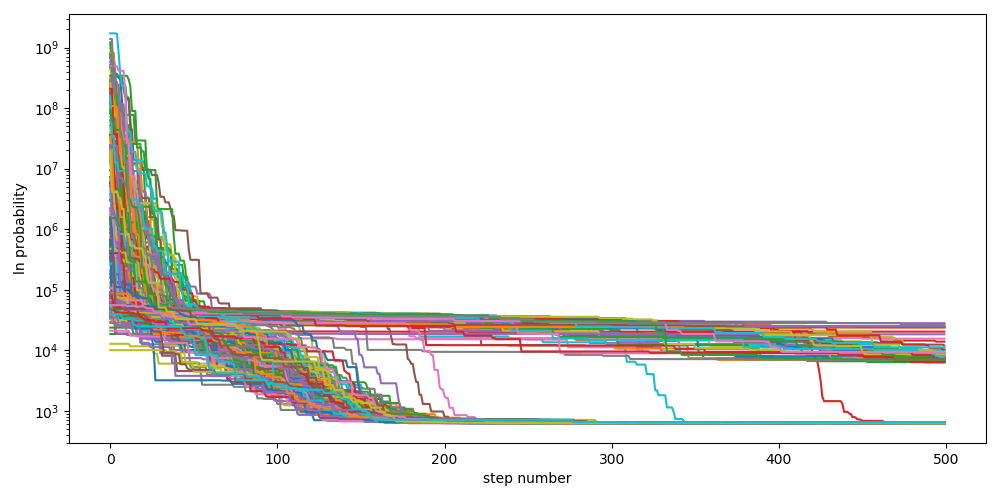

In [413]:
f0, ax0 = plt.subplots(figsize=(10, 5))
ax0.semilogy(midlnprob_shape, midlnprob_val)
ax0.set_xlabel("step number");
ax0.set_ylabel("ln probability");
plt.tight_layout(pad=1);
if SV == 2:
    plt.savefig(addn+'lnprob_burnin_'+str(len(new_good_indices))+addc+'.png',dpi=150)

<IPython.core.display.Javascript object>


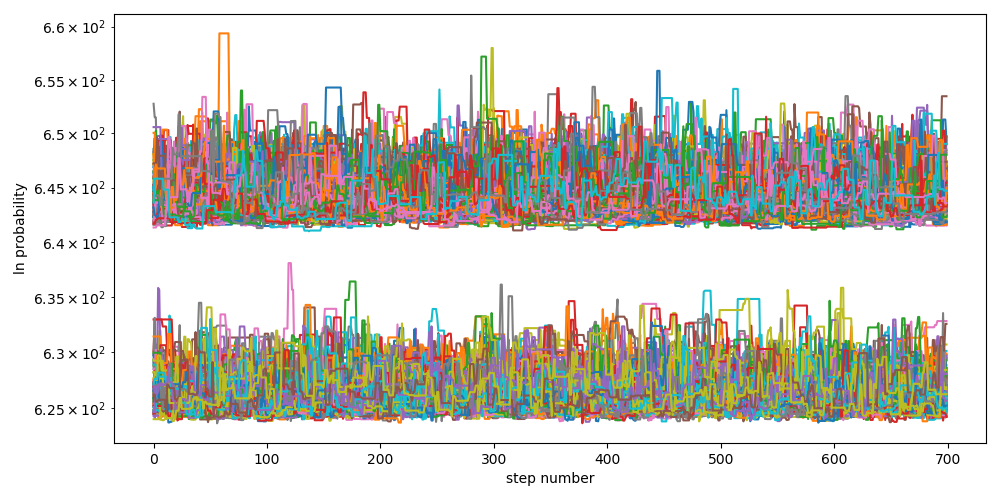

In [414]:
f, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(np.arange(sampler.lnprobability.shape[-1]), -sampler.lnprobability.T)
ax.set_xlabel("step number")
ax.set_ylabel("ln probability");
plt.tight_layout(pad=1);
if SV == 2:
    plt.savefig(addn+'lnprob'+addc+'.png',dpi=150)

In [415]:
# finding the indices for the planetary positions, regardless of alpha
# this won't work if another parameter is added within a similar order of magnitude as R_p in SI units

samples_AU = sampler.get_chain().copy()
samples5_AU = samples5.copy()
flat_samples_AU = sampler.get_chain(discard=300, flat=True).copy()

Rp_idx = samples_AU[-1,-1]>1000
samples_AU[:,:,Rp_idx] *= 1/au
samples5_AU[:,:,Rp_idx] *= 1/au

if IGD == 2 and gl_n_planets == 2:
    flat_samples_AU = np.delete(flat_samples_AU, (2,3), 1)
    Rp_idx = np.delete(Rp_idx,(2,3),0)

flat_samples_AU[:,Rp_idx] *= 1/au

<IPython.core.display.Javascript object>


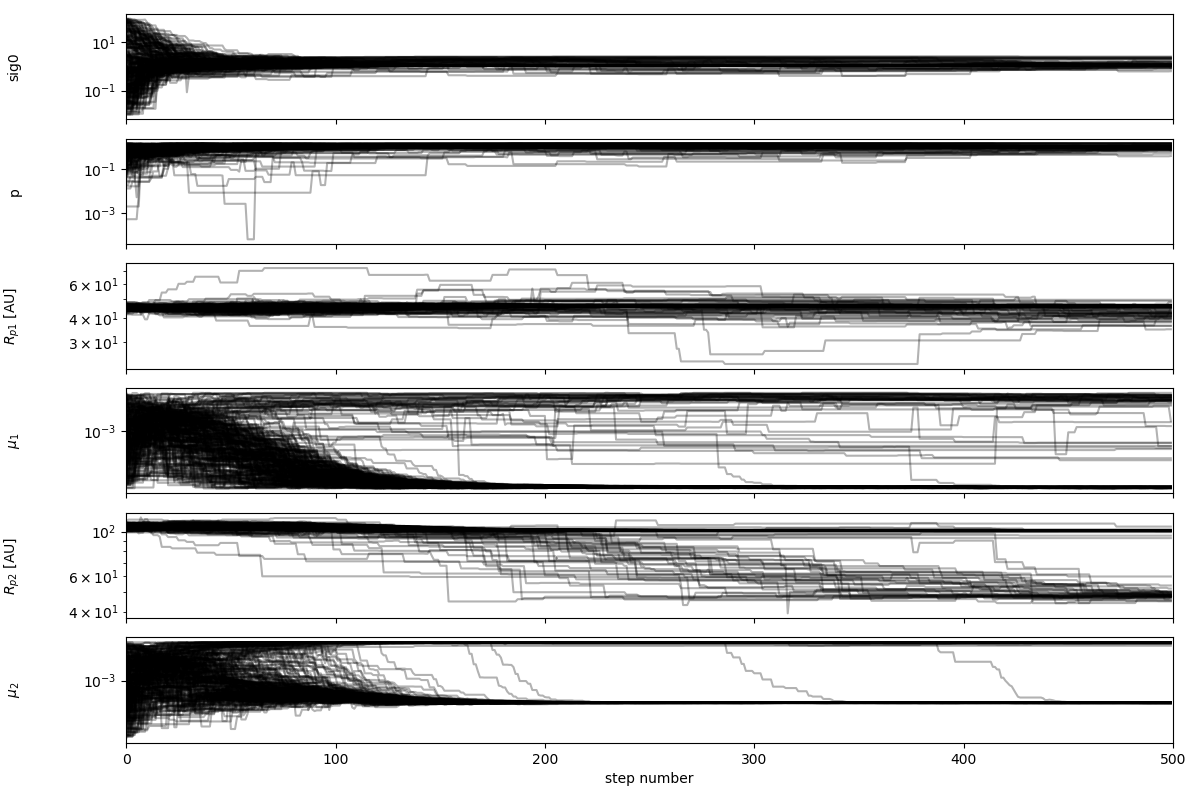

In [416]:
fig5, axes5 = plt.subplots(ndim, figsize=(12, 8), sharex=True)
labels = ["alpha", "sig0", "p"]

if set_alpha == 1:
    labels = labels[1:]

for i in range(gl_n_planets):
    labels.append(r"$R_{p"+str(i+1)+r"}$"+" [AU]")
    labels.append(r"$\mu_"+str(i+1)+r"$")
    
for i in range(ndim):
    ax5 = axes5[i]
    ax5.plot(samples5_AU[:, :, i], "k", alpha=0.3)
    ax5.set_xlim(0, len(samples5_AU))
    ax5.set_ylabel(labels[i])
    ax5.yaxis.set_label_coords(-0.1, 0.5)
    ax5.set_yscale('log')

axes5[-1].set_xlabel("step number");
plt.tight_layout(pad=1);
if SV == 2 and choose == 0:
    plt.savefig(addn+'vars5'+addc+'.png',dpi=150)

<IPython.core.display.Javascript object>


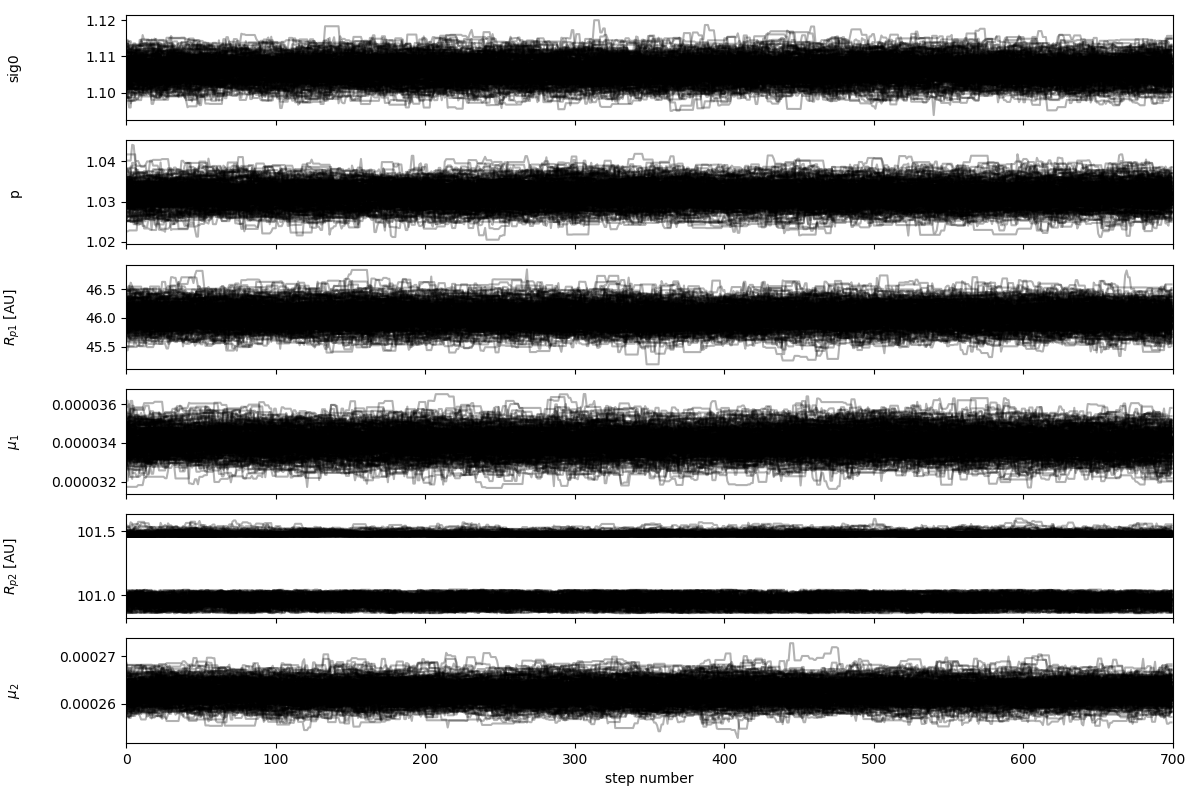

In [417]:
fig, axes = plt.subplots(ndim, figsize=(12, 8), sharex=True)
"""labels = ["alpha", "sig0", "p"]

if set_alpha == 1:
    labels = labels[1:]
    
for i in range(gl_n_planets):
    labels.append("R_p"+str(i+1)+"[AU]")
    labels.append("mu"+str(i+1))"""
    
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_AU[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_AU))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_yscale('log')

axes[-1].set_xlabel("step number");
plt.tight_layout(pad=1);
if SV == 2:
    plt.savefig(addn+'vars'+addc+'.png',dpi=150)

<IPython.core.display.Javascript object>


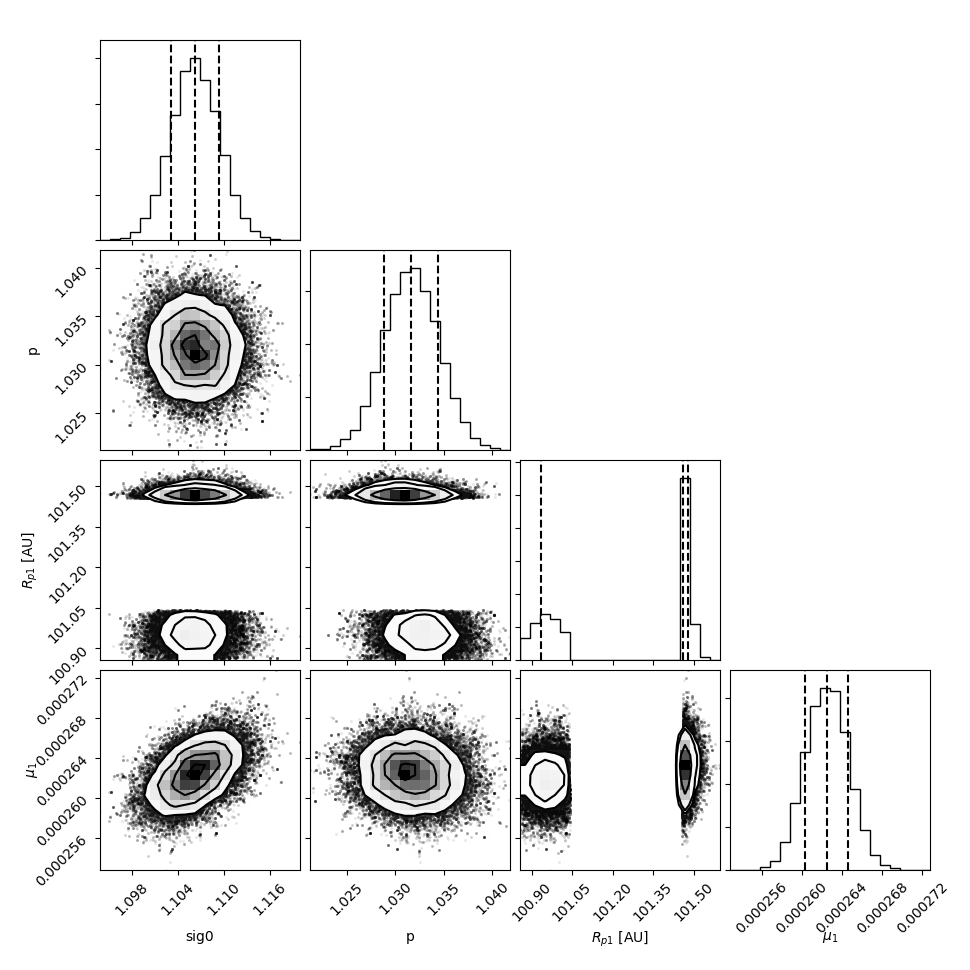

In [418]:
import corner
fig = corner.corner(flat_samples_AU, labels=labels, quantiles=[0.16, 0.5, 0.84]);
#plt.tight_layout(pad=1);
if np.any(SV == np.array([1,2])):
    plt.savefig(addn+'corner'+addc+'.png',dpi=150)

In [419]:
if set_alpha == 1:
    def params_format(params, x_data, y_data, n_planets):
        params      = np.insert(params,0,gl_alpha)
        alpha       = params[0]
        sig0        = params[1]
        p           = params[2]
        R_p         = []
        mass_ratios = []
        
        for n in range(n_planets):
            R_p         += [params[3 + 2 * n]]
            mass_ratios += [params[4 + 2 * n]]
            
        h_p = get_disk_height(np.array(R_p)).tolist()

        return x_data, alpha, sig0, p, R_p, h_p, mass_ratios

In [420]:
samples = sampler.get_chain()
flat_samples = sampler.get_chain(discard=300, flat=True)
percentiles = np.percentile(flat_samples,[16,50,84], axis=0)
mcmc = percentiles[1].tolist()

In [421]:
if np.any(SV == np.array([1,2])):
    np.save('samples_co\\'+alphan+IGDn+'samples'+addc,samples)

In [422]:
percentiles_AU = np.percentile(flat_samples_AU,[16,50,84], axis=0)
means_AU = np.mean(flat_samples_AU, axis=0).tolist()
mcmc_AU = percentiles[1].tolist()
mass_percentile = percentiles_AU[:,-1].tolist()

print("50th percentiles:")
for i in range(ndim):
    print(labels[i], ":", mcmc_AU[i])

50th percentiles:
sig0 : 1.106280616754034
p : 1.0316573874791
$R_{p1}$ [AU] : 688616812414449.0
$\mu_1$ : 3.403107465759861e-05
$R_{p2}$ [AU] : 1517824175638508.2
$\mu_2$ : 0.00026250038471954977


<IPython.core.display.Javascript object>


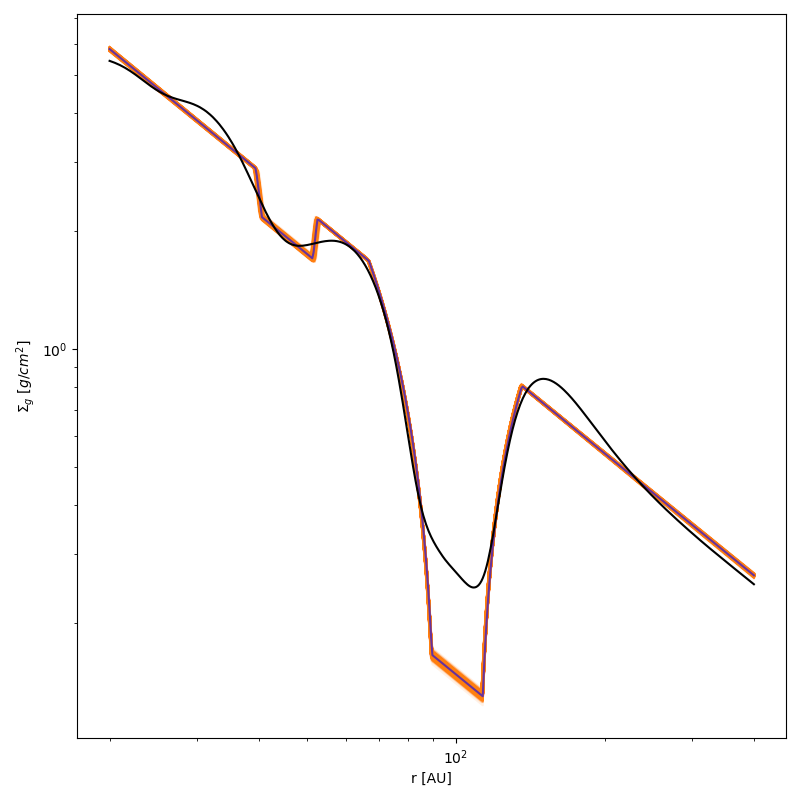

In [423]:
inds = np.random.randint(len(flat_samples), size=1000)
f, ax2 = plt.subplots(figsize=(8, 8))
surf_dens = []
for ind in inds:
    sample = flat_samples[ind]
    x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(sample, r_log, sig, gl_n_planets)
    surf_dens += [get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios)['sigma']]

surf_dens = np.array(surf_dens).transpose()
ax2.loglog(r_log / au, surf_dens, "C1", alpha=0.1)
x_data, alpha, sig0, p, R_p, h_p, mass_ratios = params_format(np.array(mcmc), r_log, sig, gl_n_planets)
ax2.loglog(r_log / au, get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios)['sigma'], "b", alpha=0.6)
ax2.loglog(r_log[0:] / au, sig[0:], "k-");
ax2.set_xlabel("r [AU]");
ax2.set_ylabel(r"$\Sigma_{g}$"+" ["+r"$g/cm^2$"+"]");
plt.tight_layout(pad=1);
if np.any(SV == np.array([1,2])):
    plt.savefig(addn+'plot'+addc+'.png',dpi=150)

In [424]:
"""269 == r_log.searchsorted(100*au)"""

# secondary information
secinf = np.array([choose, len(new_good_indices), 
                 get_surface_density(x_data, alpha, sig0, p, R_p, h_p, mass_ratios)['sigma'][268],sig[268]])

try:
    dataprim[choose]  = percentiles_AU
    dataseco[choose]  = secinf
except Exception:
    dataprim  = np.full([14, percentiles_AU.shape[0], percentiles_AU.shape[1]],1.)
    dataseco  = np.full([14,secinf.shape[0]],1.)
    dataprim[choose]  = percentiles_AU
    dataseco[choose]  = secinf

surfas = dataseco[:,2]/dataseco[:,3]
maass  = dataprim[:,1,3]/M_true_all

In [425]:
four = np.arange(4)+1
nine = np.arange(9)+5

###############
verbose = False
###############

for y in np.arange(1,14):
    chs = int(dataseco[y,0])
    if not np.all(dataprim[y] == 1):
        if verbose == True:
            print("C"+str(chs)+" ("+"a"+'{:.0e}'.format(true_alpha[chs])+", mu"+'{:.4e}'.format(M_true_all[chs])+"):")
        else:
            print("C"+str(chs)+":")
        print("new good:", '{:2d}'.format(int(dataseco[y,1]))+",  p:", '{:.4f}'.format(dataprim[y,1,1]),
              "   |  "'{:f}'.format(maass[y]), "(mu",'{:.4e}'.format(dataprim[y,1,3])+")"+
              ",  surf dens%:", '{:f}'.format(surfas[y]))

C1:
new good: 53,  p: 0.7428    |  3.091707 (mu 3.0917e-03),  surf dens%: 0.947686
C5:
new good: 37,  p: 0.9106    |  1.381013 (mu 4.1430e-03),  surf dens%: 0.230610
C6:
new good: 17,  p: 0.9538    |  1.371510 (mu 1.3715e-03),  surf dens%: 0.605729
C7:
new good: 13,  p: 0.9916    |  1.459537 (mu 4.3786e-04),  surf dens%: 0.897810
C8:
new good: 37,  p: 0.7591    |  1.397174 (mu 4.1915e-03),  surf dens%: 0.496289
C9:
new good: 18,  p: 0.8527    |  1.284795 (mu 1.2848e-03),  surf dens%: 0.435557
C10:
new good: 17,  p: 0.9539    |  1.324125 (mu 3.9724e-04),  surf dens%: 0.621482
C11:
new good: 14,  p: 0.9447    |  0.845368 (mu 2.5361e-03),  surf dens%: 3.639741
C12:
new good: 53,  p: 0.9645    |  0.708138 (mu 7.0814e-04),  surf dens%: 0.897888
C13:
new good: 49,  p: 1.0317    |  0.875001 (mu 2.6250e-04),  surf dens%: 0.548536


In [426]:
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.3e' % x))
fmt = mticker.FuncFormatter(g)

In [427]:
# LaTeX table print
print("Set parameters & $\\Sigma_0$ & p & $R_\\ttt{p}$ & $\\mu_\\ttt{p}$ & $\\mu_\\ttt{p} / \\mu_\\ttt{s}$ & surface density ratio \\\\")
print("\\hline")
for r in range(14):
    if not np.all(dataprim[r] == 1):
        #print("C"+str(int(alsg[y,4]))+":")
        print('C'+'{:.0f}'.format(dataseco[r,0]),'&','{:.3f}'.format(dataprim[r,1,0]),"&", '{:.4f}'.format(dataprim[r,1,1]),"&",
              '{:.2f}'.format(dataprim[r,1,2]), "&",'{}'.format(fmt(dataprim[r,1,3])),"&",
              '{:.3f}'.format(maass[r]),"&",'{:.3f}'.format(surfas[r]),"\\\\")

""" "$\\alpha$"+'{:.0e}'.format(true_alpha[int(alsg[r,4])])+", $\\mu$"+'{:.0e}'.format(M_true_all[int(alsg[r,4])]),"&",""";

Set parameters & $\Sigma_0$ & p & $R_\ttt{p}$ & $\mu_\ttt{p}$ & $\mu_\ttt{p} / \mu_\ttt{s}$ & surface density ratio \\
\hline
C1 & 3.606 & 0.7428 & 99.72 & $3.092{\times}10^{-3}$ & 3.092 & 0.948 \\
C5 & 0.875 & 0.9106 & 100.43 & $4.143{\times}10^{-3}$ & 1.381 & 0.231 \\
C6 & 0.931 & 0.9538 & 99.01 & $1.372{\times}10^{-3}$ & 1.372 & 0.606 \\
C7 & 0.981 & 0.9916 & 99.44 & $4.379{\times}10^{-4}$ & 1.460 & 0.898 \\
C8 & 0.881 & 0.7591 & 99.43 & $4.192{\times}10^{-3}$ & 1.397 & 0.496 \\
C9 & 0.918 & 0.8527 & 99.21 & $1.285{\times}10^{-3}$ & 1.285 & 0.436 \\
C10 & 0.958 & 0.9539 & 98.11 & $3.972{\times}10^{-4}$ & 1.324 & 0.621 \\
C11 & 1.165 & 0.9447 & 103.06 & $2.536{\times}10^{-3}$ & 0.845 & 3.640 \\
C12 & 1.106 & 0.9645 & 101.05 & $7.081{\times}10^{-4}$ & 0.708 & 0.898 \\
C13 & 1.106 & 1.0317 & 101.46 & $2.625{\times}10^{-4}$ & 0.875 & 0.549 \\


In [428]:
new_choose = choose+1
if new_choose > chigh:
    new_choose = clow
new_choose

11

In [429]:
# Heat Map

import pandas as pd
# se 0 for 2x2 heatmap (1st set of planets), se 1 for 3x3 (2nd set of planets)
se = 1
squared = 1

maassf = maass.copy()
maassf[maassf<1] = 1/maass[maass<1]

slicer = [slice(1,5), slice(5,14)]
uniform_data = [maass[slicer[se]],maassf[slicer[se]]]
uniform_data = uniform_data[squared]
sqr = int(np.sqrt(len(uniform_data)))
uniform_data.shape = (sqr,-1)

pd_label = np.array([[[1e-2, 1e-3],[1e-2,1e-3,1e-4]],[[1e-3, 4e-4],[3e-3,1e-3,3e-4]]])
figname = ["set4", "set9"]
sq_name = ['','_abs']
uniform_data = pd.DataFrame(uniform_data,columns=pd_label[1,se],index=pd_label[0,se])
if SV == 1:
    uniform_data.to_csv('samples\\'+figname[se]+"_heatmap"+sq_name[squared]+IGDn+'.cvs')
uniform_data
#'samples\\'+figname[se]+"_heatmap"+sq_name[squared]+IGDn+'.cvs'

,0.0030,0.0010,0.0003
0.0100,1.381013,1.371510,1.459537
0.0010,1.397174,1.284795,1.324125
0.0001,1.182916,1.412154,1.142855


In [ ]:
uniform data = pd.read_csv('samples\\'+figname[se]+"_heatmap"+sq_name[squared]+IGDn+'.cvs',index_col=0)

<IPython.core.display.Javascript object>


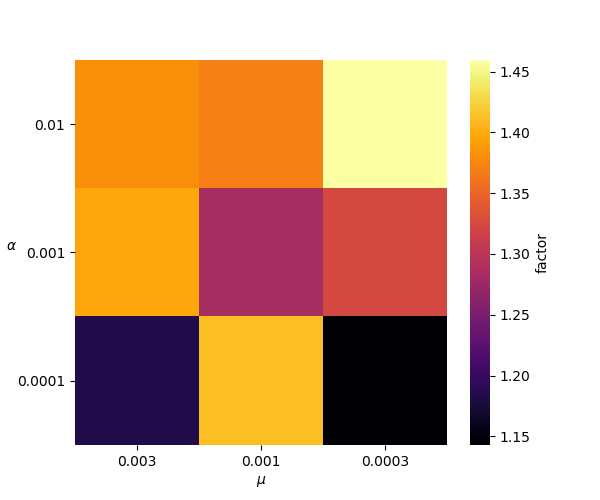

In [435]:
import seaborn as sns;# sns.set_theme()

f8, ax8 = plt.subplots(figsize=(6, 5))

ax8 = sns.heatmap(uniform_data, cmap=["coolwarm",'inferno'][squared], center=[1,None][squared], cbar_kws={'label':'factor'})
# , 'norm':'colors.LogNorm(vmin=.5, vmax=2.)'
ax8.set_xlabel(r"$\mu$")
ax8.set_ylabel(r"$\alpha$", rotation=0)
ax8.set_yticklabels(ax8.get_yticklabels(),rotation=0);

if SV == 1:
    #plt.savefig('figures_cm\\'+figname[se]+IGDn+"heatmap"+sq_name[squared]+'.png')